# Measuring Degrees of Semantic Change

In [1]:
% pip install transformers

     |████████████████████████████████| 552kB 3.4MB/s 
     |████████████████████████████████| 870kB 64.5MB/s 
     |████████████████████████████████| 3.7MB 43.4MB/s 
     |████████████████████████████████| 1.0MB 45.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=0e5551151e8a454ba650113e10835bd5dbed42790176c78e39adaa34438eb135
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

% cd /content/gdrive/My\ Drive/UofT/CSC2611/Project

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/UofT/CSC2611/Project


In [0]:
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertForMaskedLM, DistilBertTokenizer, \
  get_linear_schedule_with_warmup, AdamW
import json
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, \
    RandomSampler, SequentialSampler
import pylab
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE as T
from sklearn.decomposition import TruncatedSVD
from scipy.stats import spearmanr, pearsonr, rankdata
from scipy.spatial.distance import jensenshannon
import seaborn as sns

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [0]:
def tokenize_inputs(tokenizer, sentences, add_special_tokens=True):
    """
    Use the tokenizer given to tokenize the sentences into their IDs.
    """
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = tokenizer.encode(
            sentence, 
            add_special_tokens=add_special_tokens,
            max_length=512
            )
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences


def pad_inputs(tokenized_sentences, padding_token=0):
    """
    Return the padded sentences where each sentence is padded with 0's so that
    all sentences have the length of the longest sentence.
    """
    max_len = max([len(sentence) for sentence in tokenized_sentences])

    return pad_sequences(tokenized_sentences, maxlen=max_len, dtype="long",
                         value=padding_token, truncating="post", padding="post")


def get_padding_mask(padded_sentences):
    """
    Return a list of masks, one for each tokenized sentence, where at each
    position of the sentence, if the token has a non-zero value, then the token
    has meaning and thus is not a padding token and will have value 1 in the
    corresponding position in the mask, otherwise, the token is a padding token
    and will have value 0 in the corresponding position in the mask.
    """
    return padded_sentences > 0


def get_train_val_loader(inputs, masks, batch_size, train_split=0.8):
    """
    Return the train and validation data loader.
    """
    assert 0 < train_split < 1, \
        "train_split needs to be a fraction between 0 and 1 exclusive"
    num_train = int(np.ceil(inputs.size(0) * train_split))
    num_val = int(inputs.size(0) - num_train)

    assert num_train and num_val, \
        f"the train_split given ({train_split}) resultted in either the " \
        f"number of training or validation examples being 0, which is " \
        f"invalid"

    uniform_dist = torch.ones(inputs.size(0)) / inputs.size(0)
    train_indices = torch.multinomial(uniform_dist, num_train, replacement=False)
    used = set([int(num) for num in train_indices])
    val_indices = torch.tensor(
        [i for i in range(inputs.size(0)) if i not in used]
    )

    train_inputs, train_masks = inputs[train_indices], masks[train_indices]

    val_inputs, val_masks = inputs[val_indices], masks[val_indices]

    train_data = TensorDataset(train_inputs, train_masks)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, batch_size, sampler=train_sampler)

    val_data = TensorDataset(val_inputs, val_masks)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, batch_size, sampler=val_sampler)

    return train_dataloader, val_dataloader

In [6]:
model_corpus1 = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
model_corpus2 = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

In [0]:
def mask_tokens(inputs, tokenizer):
    """ 
    Prepare masked tokens inputs/labels for masked language modeling: 
    80% MASK, 10% random, 10% original. 
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for \
            masked language modeling. Remove the --mlm flag if you want to use \
            this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training 
    # (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) 
        for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, 
                                                 dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens 
    # with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(
        torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels


def train(model, optimizer, scheduler, device, train_dataloader, tokenizer,
          name="bert_corpus1", max_iter=None):
    step = 1
    total_iters = len(train_dataloader) * epochs
    total_loss = 0
    for epoch in range(epochs):
      model.train()
      train_losses = []
      for inputs, masks in train_dataloader:
          model.zero_grad()
          inputs, labels = mask_tokens(inputs, tokenizer)
          inputs = inputs.to(device)
          masks = masks.to(device)
          labels[~masks] = -100 # we do not compute loss on the padding tokens
          labels = labels.to(device)
          outputs = model(
              inputs,
              attention_mask=masks,
              masked_lm_labels=labels
          )

          loss = outputs[0]
          total_loss += loss.item()
          train_losses.append(loss)
          if not (step % 100):
            print(f"At iteration {step}/{total_iters}; Avg Loss: {total_loss/100}")
            total_loss = 0
            if not (step % 1000):
              print(f"Saving checkpoint at step {step}...")
              torch.save(model.state_dict(), f"checkpoints/{name}_checkpoint.tar")
              print("Checkpoint saved...")
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          scheduler.step()

          if max_iter is not None and step >= max_iter:
            break
            
          step += 1

          del loss
          del inputs
          del masks
          del labels
          del outputs
          torch.cuda.empty_cache()
    return train_losses 


def validate(model, device, val_dataloader, max_batches=None):
    model.eval()
    step = 1
    for inputs, masks in val_dataloader:
        inputs, labels = mask_tokens(inputs, tokenizer)
        inputs = inputs.to(device)
        masks = masks.to(device)
        labels[~masks] = -100 # we do not compute loss on the padding tokens
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(
                inputs,
                attention_mask=masks,
                masked_lm_labels=labels
            )

        loss = outputs[0]

        if max_batches is not None and step >= max_batches \
          or step == len(val_dataloader):
          return loss.item()
          
        del loss
        del inputs
        del masks
        del labels
        del outputs
        torch.cuda.empty_cache()

        step += 1
    

In [0]:
corpus1 = open("ccoha1.txt").readlines()[:]
corpus1 = [line.strip() for line in corpus1]
corpus2 = open("ccoha2.txt").readlines()[:]
corpus2 = [line.strip() for line in corpus2]

In [0]:
seed = 42
batch_size = 64
epochs = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Finetune BERT on corpora from 2 different time periods

In [12]:
from_checkpoint = True
checkpoint_corpus1 = "bert_corpus1_weights.tar"
max_iter = None

do_train_corpus1 = False
torch.cuda.empty_cache()
if from_checkpoint:
  print("Loading checkpoint...")
  model_corpus1.load_state_dict(torch.load(checkpoint_corpus1, map_location="cpu"))
model_corpus1 = model_corpus1.to(device)
if do_train_corpus1:
  tokenized_corpus1 = tokenize_inputs(tokenizer, corpus1)
  padded_corpus1 = pad_inputs(tokenized_corpus1, tokenizer.pad_token_id)
  masks_corpus1 = get_padding_mask(padded_corpus1)

  inputs_corpus1 = torch.tensor(padded_corpus1)
  masks_corpus1 = torch.tensor(masks_corpus1)
  corpus1_train_dataloader, corpus1_val_dataloader = get_train_val_loader(
      inputs_corpus1,
      masks_corpus1,
      batch_size
  )

  del tokenized_corpus1
  del padded_corpus1
  del masks_corpus1
  del inputs_corpus1
  total_iterations = len(corpus1_train_dataloader) * epochs
  parameters = []
  for name, param in model_corpus1.named_parameters():
    if name == "distilbert.embeddings.word_embeddings.weight":
        parameters.append(param)
    else:
      param.requires_grad_(False)

  parameters = nn.ParameterList(parameters)
  corpus1_optimizer = AdamW(parameters, lr=2e-5)
  corpus1_scheduler = get_linear_schedule_with_warmup(
      corpus1_optimizer, 0, total_iterations)

  train_loss = train(model_corpus1, corpus1_optimizer, corpus1_scheduler, 
                     device, corpus1_train_dataloader, tokenizer)
  torch.save(model_corpus1.state_dict(), "bert_corpus1_weights.tar")

  validate_loss = validate(model_corpus1, device, corpus1_val_dataloader, 1000)

  graph_losses = [loss.item() for loss in train_loss]
  print(graph_losses[:10])
  plt.plot(graph_losses)
  plt.show()
  print(validate_loss)

Loading checkpoint...


In [0]:
batch_size = 16
epochs = 1

In [14]:
from_checkpoint = True
checkpoint_corpus2 = "bert_corpus2_weights.tar"
max_iter = None

do_train_corpus2 = False
torch.cuda.empty_cache()
if from_checkpoint:
  print("Loading checkpoint...")
  model_corpus2.load_state_dict(torch.load(checkpoint_corpus2, map_location="cpu"))
model_corpus2 = model_corpus2.to(device)
if do_train_corpus2:
  # tokenized_corpus2 = tokenize_inputs(tokenizer, corpus2)
  # padded_corpus2 = pad_inputs(tokenized_corpus2, tokenizer.pad_token_id)
  # masks_corpus2 = get_padding_mask(padded_corpus2)

  # inputs_corpus2 = torch.tensor(padded_corpus2)
  # masks_corpus2 = torch.tensor(masks_corpus2)

  # torch.save(inputs_corpus2, "inputs_corpus2.tar")
  # torch.save(masks_corpus2, "masks_corpus2.tar")

  inputs_corpus2 = torch.load("inputs_corpus2.tar", map_location="cpu")
  masks_corpus2 = torch.load("masks_corpus2.tar", map_location="cpu")
  corpus2_train_dataloader, corpus2_val_dataloader = get_train_val_loader(
      inputs_corpus2,
      masks_corpus2,
      batch_size
  )

  # del tokenized_corpus2
  # del padded_corpus2
  del masks_corpus2
  del inputs_corpus2
  total_iterations = len(corpus2_train_dataloader) * epochs
  parameters = []
  for name, param in model_corpus2.named_parameters():
    if name == "distilbert.embeddings.word_embeddings.weight":
        parameters.append(param)
    else:
      param.requires_grad_(False)

  parameters = nn.ParameterList(parameters)
  corpus2_optimizer = AdamW(parameters, lr=2e-5)
  corpus2_scheduler = get_linear_schedule_with_warmup(
      corpus2_optimizer, 0, total_iterations)

  train_loss = train(model_corpus2, corpus2_optimizer, corpus2_scheduler, 
                     device, corpus2_train_dataloader, tokenizer, "bert_corpus2")
  torch.save(model_corpus2.state_dict(), "bert_corpus2_weights.tar")
  graph_losses = [loss.item() for loss in train_loss]
  plt.plot(graph_losses)
  plt.show()

Loading checkpoint...


In [0]:
with open("expected_div.txt") as f:
  expected_div = f.readlines()[:]
  expected_div = [line.strip().split("\t") for line in expected_div]
  expected_div = {word[:-3]: float(val) for word, val in expected_div}
  f.close()

In [0]:
def cosine_distance(matrix1, matrix2):
  dot = np.einsum("ij,ij->i", matrix1, matrix2)
  norm1 = np.linalg.norm(matrix1, axis=1)
  norm2 = np.linalg.norm(matrix2, axis=1)
  
  return 1 - dot / (norm1 * norm2)


def euclidean_distance(matrix1, matrix2):
  diff = matrix1 - matrix2
  dist = (diff ** 2).sum(axis=1)

  return dist ** 0.5

In [0]:
class TSNE:
    """
    t-SNE projection for dimensionality reduction.
    """
    def __init__(self, high_dim_data, perplexity=1e-5, tolerance=30.0, 
                 normalize=False):
        """
        Initialize an instance of t-SNE analysis class.
        """
        self.data = high_dim_data
        self.perplexity = perplexity
        self.tolerance = tolerance
        if normalize:
          self.transform_stable()

    def transform_stable(self):
        """
        Normalize the data and then remove NaN data points.
        """
        data = self.data
        data = np.nan_to_num(
            (data - np.mean(data, axis=0)) / np.std(data, axis=0), 0)
        self.data = data

    def pairwise_distance(self, data=None):
        """
        Compute the pairwise distances of all the high dimensional data stored.
        """
        if data is None:
            data = self.data
        assert len(data.shape) == 2
        diff = data[:, None] - data
        dist = (diff ** 2).sum(axis=2)

        return dist

    @staticmethod
    def compute_probs(distance, sigma, word_pos):
        """
        Compute the probability distribution of neighbors of the word at
        <word_pos>
        """
        neg_dist = -distance / (2 * sigma ** 2)
        exp_neg_dist = np.exp(neg_dist)

        exp_neg_dist[word_pos] = 0

        probs = exp_neg_dist / exp_neg_dist.sum()
        return probs

    @staticmethod
    def compute_perplexity(probs, word_pos):
        """
        Return the perplexity of the probability distribution of neighbors
        of the word at <word_pos>.
        """
        log_probs = np.log2(probs)
        log_probs[word_pos] = 0
        return 2 ** -(probs * log_probs).sum()

    def get_sigma(self, distance, word_pos, sigmas):
        """
        Compute the appropriate sigma value for probability distribution
        computation such that the perplexity is the same for all words'
        probability distributions.
        """
        perplexity, tolerance = self.perplexity, self.tolerance
        min_val, max_val = -float("inf"), float("inf")

        iters = 0
        probs = self.compute_probs(distance, sigmas[word_pos], word_pos)
        computed_perplexity = self.compute_perplexity(probs, word_pos)
        diff = perplexity - computed_perplexity
        at_limit = False

        while abs(diff) > tolerance and iters < 50:
            if diff > 0:
                min_val = sigmas[word_pos]
                if at_limit:
                    sigmas[word_pos] = (min_val + max_val) / 2
                else:
                    max_val = sigmas[word_pos] * 2
                    sigmas[word_pos] = max_val
            else:
                max_val = sigmas[word_pos]
                sigmas[word_pos] = (min_val + max_val) / 2
                at_limit = True

            probs = self.compute_probs(distance, sigmas[word_pos], word_pos)
            computed_perplexity = self.compute_perplexity(probs, word_pos)
            diff = perplexity - computed_perplexity
            iters += 1

        return probs

    def get_probs_dists(self, data=None):
        """
        Compute the probability distribution for each word.
        """
        if data is None:
          data = self.data

        num_words = data.shape[0]

        distances = self.pairwise_distance(data)
        scaled_distances = distances / distances.std(axis=-1) * 10

        final_probs = np.zeros((num_words, num_words))
        sigmas = np.ones(num_words)

        for word_pos in range(num_words):
            distance = scaled_distances[word_pos]
            final_probs[word_pos] = self.get_sigma(distance, word_pos, sigmas)

        return final_probs

    def pca(self, data=None, target_dim=None):
        if data is None:
          data = self.data
        eigenvectors, eigenvalues = np.linalg.eig(data.T @ data)
        if target_dim:
            return np.real(data @ eigenvalues[:, :target_dim])
        else:
            variances = eigenvectors / sum(eigenvectors)

            total = 0
            for i, var in enumerate(variances):
                total += var
                if total >= 0.8:
                    return np.real(data @ eigenvalues[:, :i])

    def project(self, num_words, lr, momentum, target_dim, max_iter, do_pca=True, pca_dim=2):
        """
        Run tsne using gradient descent.
        """
        if do_pca:
          original_probs = self.get_probs_dists(self.pca(target_dim=pca_dim))
        else:
          original_probs = self.get_probs_dists()
        
        n = num_words
        new_dist = np.random.normal(loc=0, scale=0.01, size=(n, target_dim))

        v = 0
        for iter in range(max_iter):
            pairwise_new_dist = self.pairwise_distance(new_dist)
            q = 1 / (1 + pairwise_new_dist)
            np.fill_diagonal(q, 0)
            Q = q / np.sum(q, axis=1, keepdims=True)
            new_dist_flat = new_dist.flatten()
            d = new_dist_flat.reshape(target_dim, n, 1, order='F') \
                - new_dist_flat.reshape(target_dim, 1, n, order='F')
            
            CE = -original_probs * np.log2(Q)
            np.fill_diagonal(CE, 0)

            gd = 4 * (original_probs - Q) * q * d
            gradient = np.sum(gd, axis=2).T

            v = lr * gradient + momentum * v
            new_dist -= v

        return new_dist


In [0]:
embeddings_corpus1 = model_corpus1.distilbert.embeddings.word_embeddings.weight
embeddings_corpus2 = model_corpus2.distilbert.embeddings.word_embeddings.weight

embeddings1 = torch.zeros(len(expected_div), 768)
embeddings2 = torch.zeros(len(expected_div), 768)
word_to_idx = {}
for i, word in enumerate(expected_div):
  word_to_idx[word] = i
  word_idx = tokenizer.encode(word, add_special_tokens=False)
  embedding1 = torch.zeros(768).to(device)
  embedding2 = torch.zeros(768).to(device)
  for idx in word_idx:
    embedding1 += embeddings_corpus1[idx]
    embedding2 += embeddings_corpus2[idx]
  
  embeddings1[i] = embedding1.cpu().detach()
  embeddings2[i] = embedding2.cpu().detach()

embeddings1 = embeddings1.cpu().detach().numpy()
embeddings2 = embeddings2.cpu().detach().numpy()

In [19]:
target_dim = 2
max_iter = 1000
learning_rate = 0.1
momentum = 0.9
num_words = embeddings1.shape[0]

compute_distance = True

if compute_distance:
  np.random.seed(986)
  tsne1 = TSNE(embeddings1)
  tsne2 = TSNE(embeddings2) 
  embeddings_first_corpus = tsne1.project(num_words, learning_rate, momentum, target_dim, max_iter)
  embeddings_second_corpus = tsne2.project(num_words, learning_rate, momentum, target_dim, max_iter)
  
  cosine_distances = cosine_distance(embeddings_first_corpus, embeddings_second_corpus)

  actual = []
  true = []
  for word in expected_div:
    true.append(expected_div[word])
    idx = word_to_idx[word]
    actual.append(cosine_distances[idx])

else:
  actual = np.load("actual_cosine.npy")
  true = np.load("true_dist.npy")  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in multiply


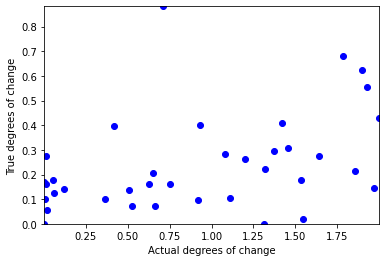

In [20]:
for x, y in zip(actual, true):
  plt.plot(x, y, "bo")

plt.xlim(min(actual), max(actual))
plt.ylim(min(true), max(true))
plt.xlabel("Actual degrees of change")
plt.ylabel("True degrees of change")
plt.show()

In [21]:
pearson_coeff_cos = pearsonr(actual, true)[0]
pearson_coeff_cos

0.4048000664528801

In [22]:
rank_actual, rank_true = rankdata(actual), rankdata(true)
spearmanr(rank_actual, rank_true)

SpearmanrResult(correlation=0.4633351190704831, pvalue=0.003876690166143042)

In [0]:
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}

cos_degree_of_change = {}
euc_degree_of_change = {}
for i in range(embeddings1.shape[0]):
  word = idx_to_word[i]
  cos_degree_of_change[word] = cosine_distances[i]

with open("cos_degree_of_change.json", "w+") as f:
  json.dump(cos_degree_of_change, f)
  f.close()

In [0]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
def plot_embeddings_2d(embeddings, words, skips, save_path=None):
  pylab.figure()
  for i, word in enumerate(words):
    if word in skips:
      continue
    x, y = embeddings[i]
    pylab.text(x, y, word)
  x_min, x_max = embeddings[:, 0].min(), embeddings[:, 0].max()
  y_min, y_max = embeddings[:, 1].min(), embeddings[:, 1].max()
  print(x_min, x_max, y_min, y_max)
  pylab.xlim(x_min, x_max)
  pylab.ylim(y_min, y_max)
  if save_path is not None:
    plt.savefig(save_path)
  pylab.show()

In [0]:
words = ["gay", "happy", "cheerful", "joy", "homosexual", 
         "lesbian", "mouse", "cat", "rodent", "device", "computer"]

In [26]:
indices = []
for word in words:
  indices.append(tokenizer.encode([word], add_special_tokens=False)[0])

indices = torch.tensor(indices)
embeddings1_vis = embeddings_corpus1[indices].cpu().detach().numpy()
embeddings2_vis = embeddings_corpus2[indices].cpu().detach().numpy()
np.random.seed(20)
tsne1 = TSNE(embeddings1_vis)
tsne2 = TSNE(embeddings2_vis)

target_dim = 2
max_iter = 1000
learning_rate = 0.1
momentum = 0.9
num_words = embeddings1_vis.shape[0]

embeddings1_vis = tsne1.project(num_words, learning_rate, momentum, target_dim, max_iter, False)
embeddings2_vis = tsne2.project(num_words, learning_rate, momentum, target_dim, max_iter, False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in multiply


Visualization of the word embeddings obtained from the 2 corpora

-15.135398123394047 40.14060053305019 -25.26836103842354 39.587435784451344


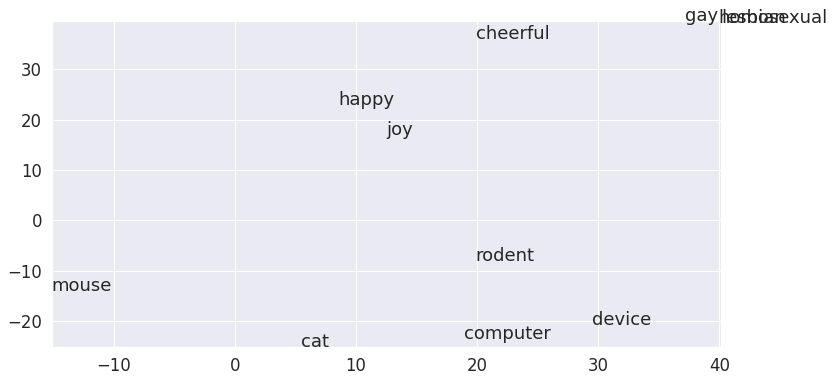

In [27]:
plot_embeddings_2d(embeddings1_vis, words, (), save_path="time1_embeddings.png")

-4.542040485620516 43.9906357531949 -31.414202867203326 27.35294113345134


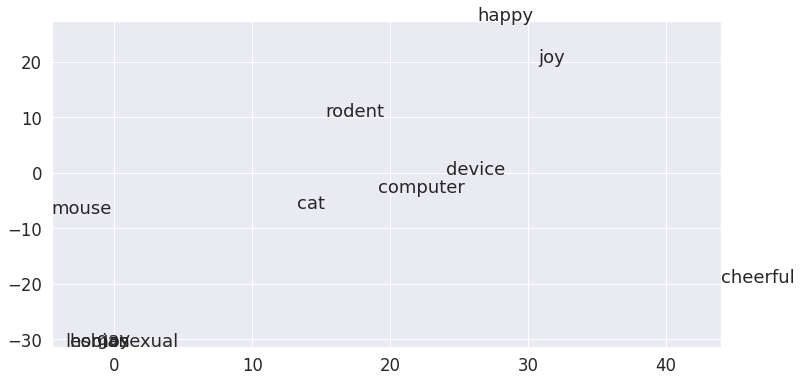

In [28]:
plot_embeddings_2d(embeddings2_vis, words, (), save_path="time2_embeddings.png")

Measure Jensen-Shannon divergence between frequencies (which can be interpreted as probability distributions)

In [31]:
with open("sense_use_ratio_compare.json") as file:
  sense_use_ratio_compare = json.load(file)

with open("word_sense_to_id_pos.json") as file:
  word_sense_to_id = json.load(file)


word_id_to_sense = {word: {
    word_sense_to_id[word][k]: k for k in word_sense_to_id[word]} 
    for word in word_sense_to_id}

for sense in sense_use_ratio_compare["attack"]:
  print(sense, word_id_to_sense["attack"][int(sense)])
sense_use_ratio_compare["attack"]

0 the act of attacking
1 (military) an offensive against an enemy (using weapons)
2 ideas or actions intended to deal with a problem or situation
3 intense adverse criticism
4 a decisive manner of beginning a musical tone or phrase
5 an offensive move in a sport or game
6 a sudden occurrence of an uncontrollable condition


{'0': [0.0022026431718061676, 0.006002400960384154],
 '1': [0.18061674008810572, 0.42016806722689076],
 '2': [0.022026431718061675, 0.006002400960384154],
 '3': [0.6475770925110133, 0.3169267707082833],
 '4': [0.0022026431718061676, 0.0012004801920768306],
 '5': [0.08590308370044053, 0.07563025210084033],
 '6': [0.05947136563876652, 0.17406962785114047]}

In [0]:
divergence = {}
for word in sense_use_ratio_compare:
  if not sense_use_ratio_compare[word]:
    continue
  p_dist = []
  q_dist = []
  for sense in sense_use_ratio_compare[word]:
    p_dist.append(sense_use_ratio_compare[word][sense][0])
    q_dist.append(sense_use_ratio_compare[word][sense][1])
  jsd = jensenshannon(p_dist, q_dist)
  divergence[word] = jsd


actual = []
true = []
for word in divergence:
  actual.append(divergence[word])
  true.append(expected_div[word])

In [40]:
divergence

{'attack': 0.26700679985238773,
 'bag': 0.09845271839245677,
 'ball': 0.23979994464020243,
 'bit': 0.12367509448160706,
 'chairman': 0.0,
 'circle': 0.1710430441358887,
 'contemplation': 0.027767151103355495,
 'edge': 0.17733369622327894,
 'face': 0.07140226081432696,
 'fiction': 0.0,
 'gas': 0.3322081250308525,
 'head': 0.12525819566369134,
 'land': 0.1833818529871792,
 'lane': 0.350913249554422,
 'ounce': 0.0,
 'part': 0.2159160043691186,
 'pin': 0.07077811870740301,
 'plane': 0.6417841370571471,
 'player': 0.044682663345109806,
 'prop': 0.0,
 'rag': 0.0,
 'record': 0.42566048531131356,
 'relationship': 0.10124762239909144,
 'risk': 0.15646033277433946,
 'stroke': 0.0,
 'tip': 0.14382136629969694,
 'tree': 0.0,
 'twist': 0.2193113485519269,
 'word': 0.15503911979800586}

In [42]:
print(actual)
print(true)

[0.07140226081432696, 0.2159160043691186, 0.12525819566369134, 0.42566048531131356, 0.15503911979800586, 0.17733369622327894, 0.1833818529871792, 0.1710430441358887, 0.10124762239909144, 0.0, 0.0, 0.23979994464020243, 0.6417841370571471, 0.15646033277433946, 0.3322081250308525, 0.0, 0.09845271839245677, 0.0, 0.12367509448160706, 0.0, 0.2193113485519269, 0.26700679985238773, 0.14382136629969694, 0.07077811870740301, 0.044682663345109806, 0.027767151103355495, 0.350913249554422, 0.0, 0.0]
[0.137791275, 0.161270809, 0.2952561247, 0.4273504707, 0.1793071623, 0.2609655868, 0.2234476353, 0.1710871199, 0.0562177896, 0.2765152931, 0.0207232682, 0.4093665525, 0.8823475834, 0.0, 0.1595695865, 0.2848990681, 0.1003636619, 0.624759971, 0.3065766263, 0.070838721, 0.3984926634, 0.1439699927, 0.6788987615, 0.2072118595, 0.2736674651, 0.070838721, 0.1037200629, 0.1762311532, 0.0]


In [44]:
pearsonr(actual, true)[0]

0.46723005384070926

In [45]:
rank_actual = rankdata(actual)
rank_true = rankdata(true)
print(rank_actual)
print(rank_true)

[11. 22. 15. 28. 17. 20. 21. 19. 13.  4.  4. 24. 29. 18. 26.  4. 12.  4.
 14.  4. 23. 25. 16. 10.  9.  8. 27.  4.  4.]
[ 9.  12.  22.  26.  15.  18.  17.  13.   4.  20.   3.  25.  29.   1.5
 11.  21.   7.  27.  23.   5.5 24.  10.  28.  16.  19.   5.5  8.  14.
  1.5]


In [46]:
spearmanr(rank_actual, rank_true)[0]

0.26594493875746616